In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

case_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/CTEPH_pqtl_result.pkl"
control_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/NAGA_pqtl_result.pkl"
known_loci_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/datasrc/cteph_reported_loci.xlsx"    

case_pqtl = pd.read_pickle(case_pqtl_path)
control_pqtl = pd.read_pickle(control_pqtl_path)
known_loci = pd.read_excel(known_loci_path)

In [2]:
model = "additive"

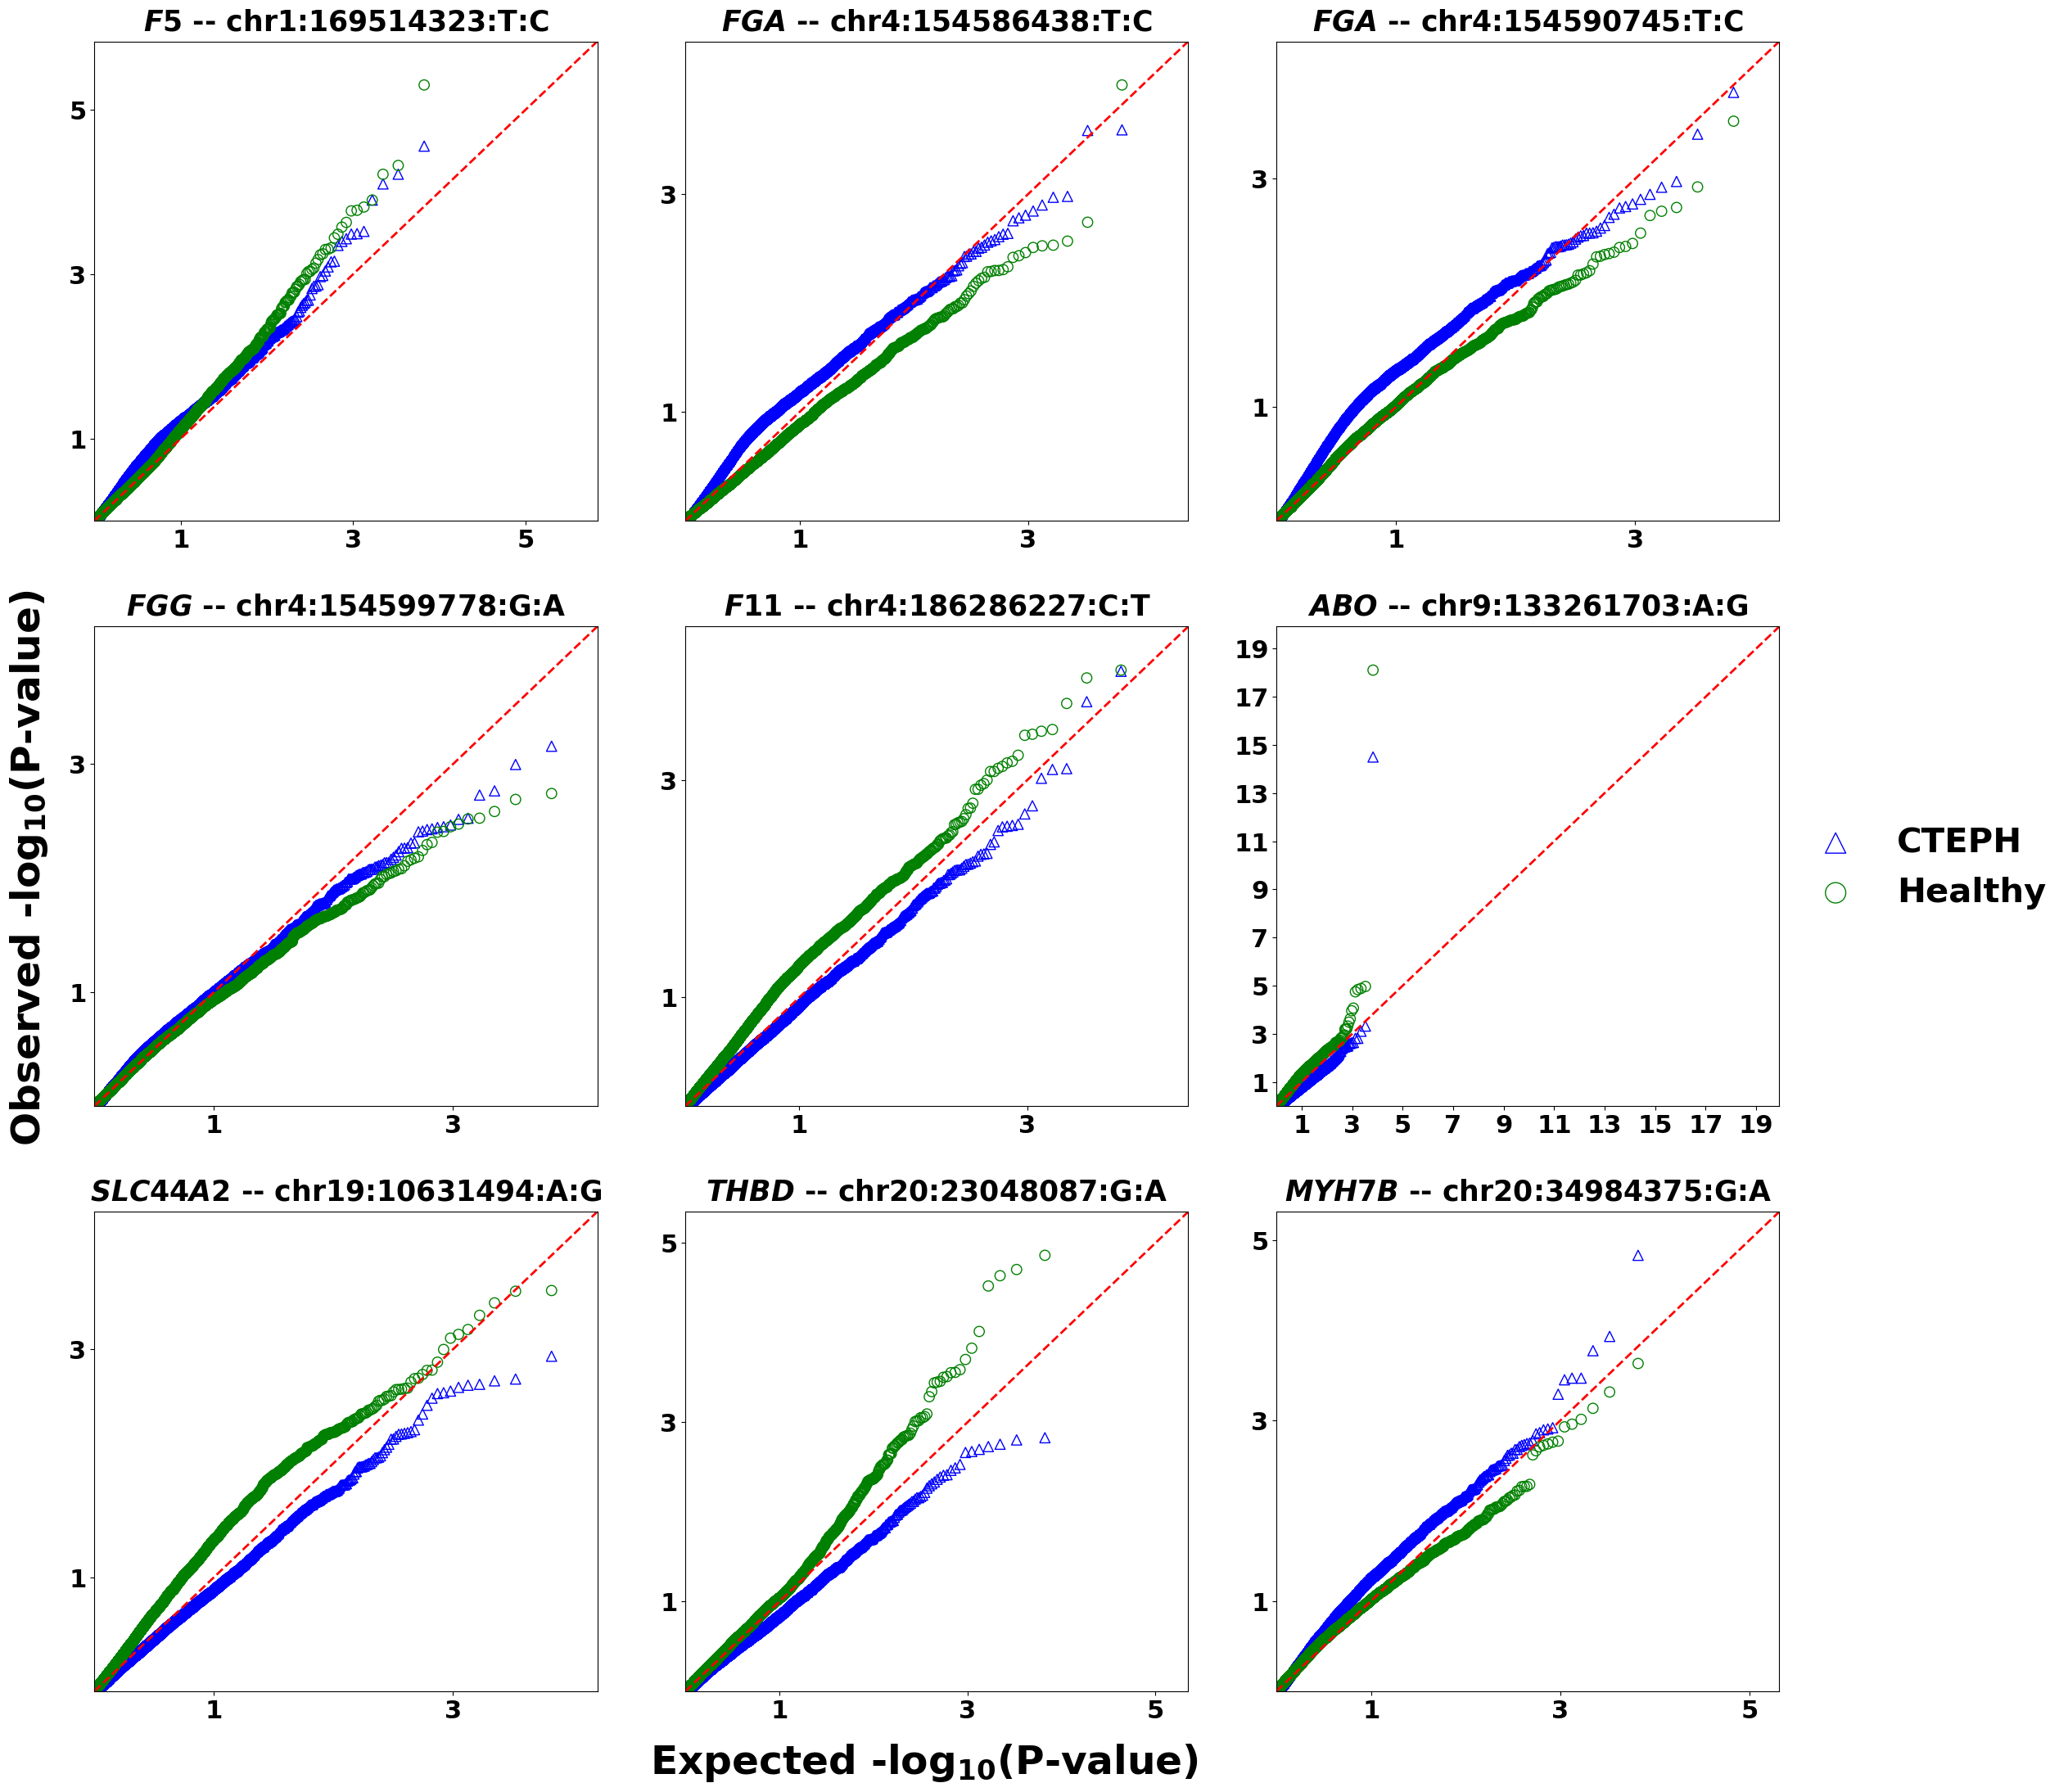

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator

plt.style.use('default')  # Set the style of the plot
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.weight'] = 'bold'

def qqplot(pvalues_case, pvalues_control, ax, label, gene, padding=0.1):
    # Sort p-values
    sorted_pval_case = np.sort(pvalues_case)
    sorted_pval_control = np.sort(pvalues_control)

    # Calculate expected -log10(p-values)
    expected_case = -np.log10(np.linspace(1/len(sorted_pval_case), 1, len(sorted_pval_case)))
    expected_control = -np.log10(np.linspace(1/len(sorted_pval_control), 1, len(sorted_pval_control)))

    # Calculate observed -log10(p-values)
    observed_case = -np.log10(sorted_pval_case)
    observed_control = -np.log10(sorted_pval_control)

    # Find max value to set equal limits
    max_val = max(max(observed_case), max(observed_control), max(expected_case), max(expected_control))
    extended_max_val = max_val + max_val * padding

    # Plotting
    ax.scatter(expected_case, observed_case, edgecolor='blue', facecolors='none', marker='^', label='CTEPH', s=80)
    ax.scatter(expected_control, observed_control, edgecolor='green', facecolors='none', marker='o', label='Healthy', s=80)
    ax.plot([0, extended_max_val], [0, extended_max_val], 'r--', linewidth=2) # Diagonal line

    # Set axis limits with padding
    ax.set_xlim(0, max_val + max_val * padding)
    ax.set_ylim(0, max_val + max_val * padding)

    ax.set_title(f'$\\it{{{gene}}}$ {"-"*2} {label}', fontsize=25, transform=ax.transAxes, verticalalignment='top', weight='bold', y=1.07)  # Title at top center
    
    # Adjust x and y ticks to show only odd integers
    odd_ticks_x = [x for x in range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1])+1) if x % 2 != 0]
    odd_ticks_y = [y for y in range(int(ax.get_ylim()[0]), int(ax.get_ylim()[1])+1) if y % 2 != 0]
    ax.xaxis.set_major_locator(FixedLocator(odd_ticks_x))
    ax.yaxis.set_major_locator(FixedLocator(odd_ticks_y))
    ax.tick_params(axis='both', which='major', labelsize=22)  # Increase tick label size

# Data preparation and plotting setup
keys = list(case_pqtl.keys())
fig, axes = plt.subplots(3, 3, figsize=(22, 22))
axes = axes.flatten()

max_val_all = 0  # Variable to store the maximum value across all plots
data = {}

# Calculate data for all keys first to determine the global max value
for key in keys:
    df_case = case_pqtl[key]
    df_control = control_pqtl[key]
    pvalues_case = df_case[f'{model}_pvalue'].values
    pvalues_control = df_control[f'{model}_pvalue'].values
    gene = known_loci.loc[known_loci['ID'] == key, 'GENE'].values[0]

    # Append data to dictionary for later access
    data[key] = (pvalues_case, pvalues_control, gene)

    # Temporary calculation to update max_val_all
    sorted_pval_case = np.sort(pvalues_case)
    sorted_pval_control = np.sort(pvalues_control)
    observed_case = -np.log10(sorted_pval_case)
    observed_control = -np.log10(sorted_pval_control)
    expected_case = -np.log10(np.linspace(1/len(sorted_pval_case), 1, len(sorted_pval_case)))
    expected_control = -np.log10(np.linspace(1/len(sorted_pval_control), 1, len(sorted_pval_control)))
    current_max = max(max(observed_case), max(observed_control), max(expected_case), max(expected_control))
    if current_max > max_val_all:
        max_val_all = current_max

# Now plot using the determined max value for uniform axis scaling
for i, key in enumerate(keys):
    pvalues_case, pvalues_control, gene = data[key]
    qqplot(pvalues_case, pvalues_control, axes[i], key, gene, padding=0.1)

# Adjust layout and provide space for global axis labels
plt.tight_layout(pad=4.0)  # Increase padding to avoid clipping of tick labels

# Add a global legend
handles, labels = axes[-1].get_legend_handles_labels()  # Use the handles and labels from the last subplot
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.14, 0.5), frameon=False, fontsize=30, markerscale=2)  # Increase font size

# Add global X and Y labels more appropriately and adjust their position
fig.text(0.5, 0.003, 'Expected -log$_{10}$(P-value)', ha='center', va='center', fontsize=35, weight='bold')  # Increase font size
fig.text(0.003, 0.5, 'Observed -log$_{10}$(P-value)', ha='center', va='center', rotation='vertical', fontsize=35, weight='bold')  # Increase font size

plt.show()
